# Trabalho prático da disciplina SCC0230 - Inteligência Artificial
### Orientadora: profª Draª Solange Oliveira Rezende

### Arthur Hiratsuka Rezende - 13687108
### Caio Assumpção Rezzadori - 11810481
### Gustavo Blois - 13688162
### João Paulo van Tol Amaral Guerra - 12557783
### Jorge Luiz Franco - 13695091

In [1]:
# Referência: https://snap.stanford.edu/grape/

from diagnostics import GNN_analysis, view_pca, plot_learning
from imputer import Experiment_Input
from prediction import Experiment_Predict

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Estrutura do trabalho:
# Dados do experimento disponíveis em:
# https://drive.google.com/file/d/1UJMoCvMuOkgzivwY4XKNxRsDSF44t68F/view?usp=sharing

# result_np.ipynb <- Compilação dos resultados
# diagnostics.py <- Análise inicial da GNN (erros, train loss, etc) e dos dados (PCA)
# imputer.py <- Código para o experimento de imputação dos dados (compilação dos resultados e visualização)
# prediction.py <- Código para o experimento de regressão dos dados (compilação dos resultados e visualização)

# Seeds usadas para aleatorizar os dados existentes/faltantes
seeds = [0, 10, 35, 51]

# Bases de dados utilizadas
data_base = ['energy', 'concrete', 'power', 'bank']

# Métodos de imputação
methods_base = ['mean', 'gnn_mdi', 'knn', 'mice', 'svd', 'spectral']

# Método de imputação das bases a serem analizadas na regressão
input_base = ['mean', 'gnn_mdi', 'knn', 'mice', 'svd', 'spectral']

# Porcentagem de dados existentes
exist_val_percent = [0.30, 0.50, 0.70, 0.90]

In [3]:
# Dados da análise inicial da GNN - Hiperparâmetros
gnn_model = GNN_analysis()

# Experimento de imputação de dados faltantes
exp = Experiment_Input(seed_list = seeds,
                       data_list = data_base,
                       input_list = methods_base,
                       value_list = exist_val_percent)

# Experimento de regressão utilizando as bases com imputações
exp_pred = Experiment_Predict(data_raw = exp.data_dict, input_grape = exp.predict_dict, input_baseline = exp.filled_dict,
                              seed_list = seeds,
                               data_list = data_base,
                               input_list = input_base,
                               value_list = exist_val_percent)

# Estudo inicial GNN - Hiperparâmetros e convergência

## Epochs
Número epochs : estudo inicial 20000
Observa-se, através do Train loss, que a GNN ainda estava aprendendo mesmo com 20000 epochs - variação em torno do loss train indica que há necessidade de otimizar arquitetura da rede (número camadas, etc) e/ou parâmetros
Com muitos dados faltantes (30% existentes) RMSE mínimo atingido mínimo no início e estabiliza em um valor maior
Com poucos dados faltantes (90% existentes) RMSE mínimo atingido quase no fim do treino
Nenhum dos casos atingiu Earlystop com tol = 1e-3 e patience = 5 

Conclusão: Por critério de tempo experimentos terao 12000 epochs

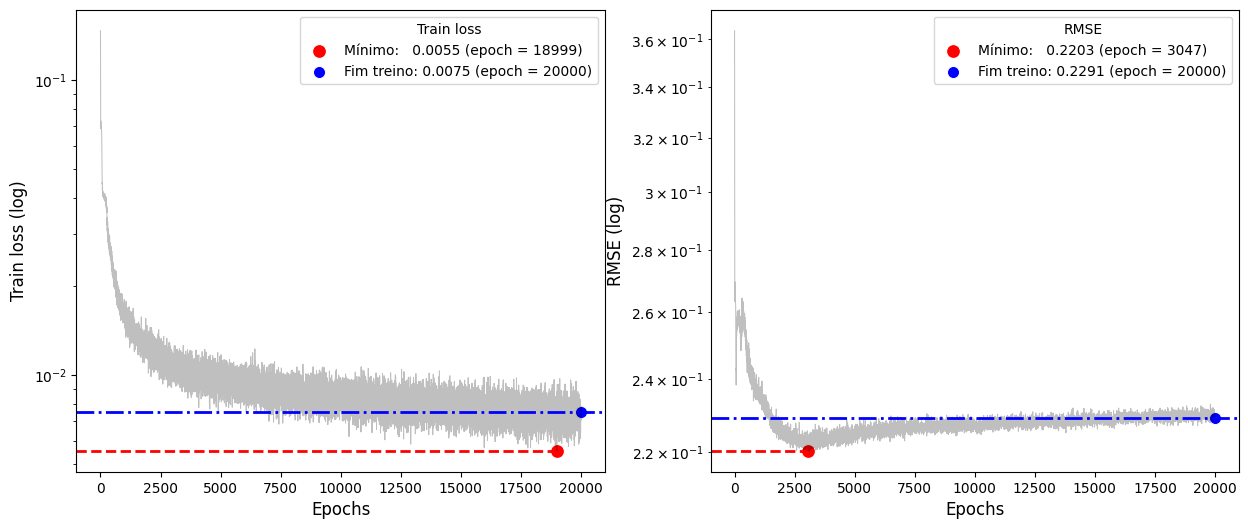

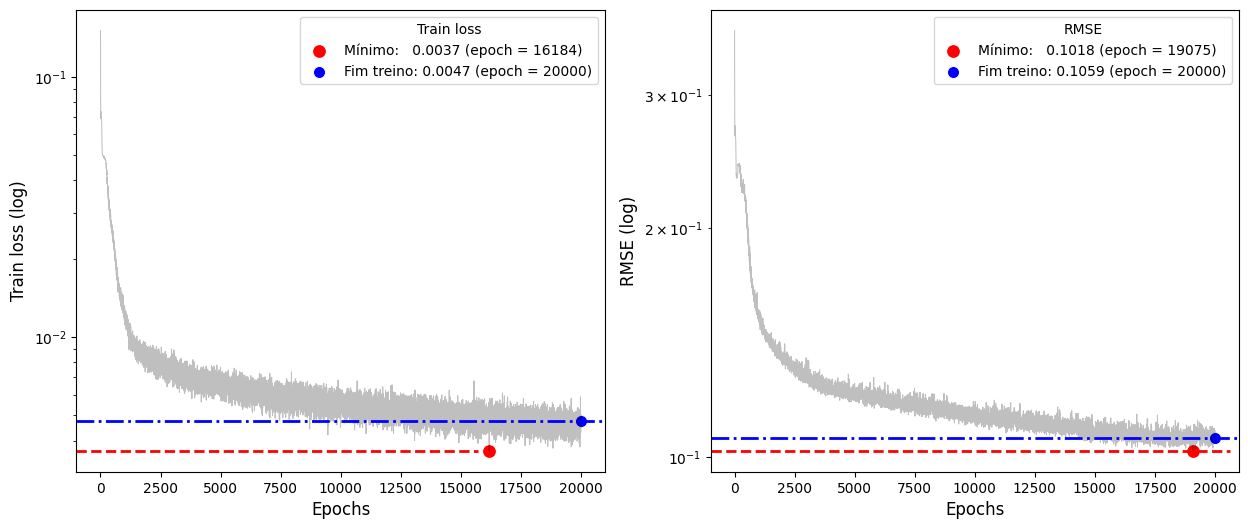

In [4]:
# plot_learning(exp.dict_metadata, seed, dataset, % valores existentes)
plot_learning(exp.dict_metadata, 0, "concrete", 0.3) # Base concreto com 30% valores existentes
plot_learning(exp.dict_metadata, 0, "concrete", 0.9) # Base concreto com 90% valores existentes

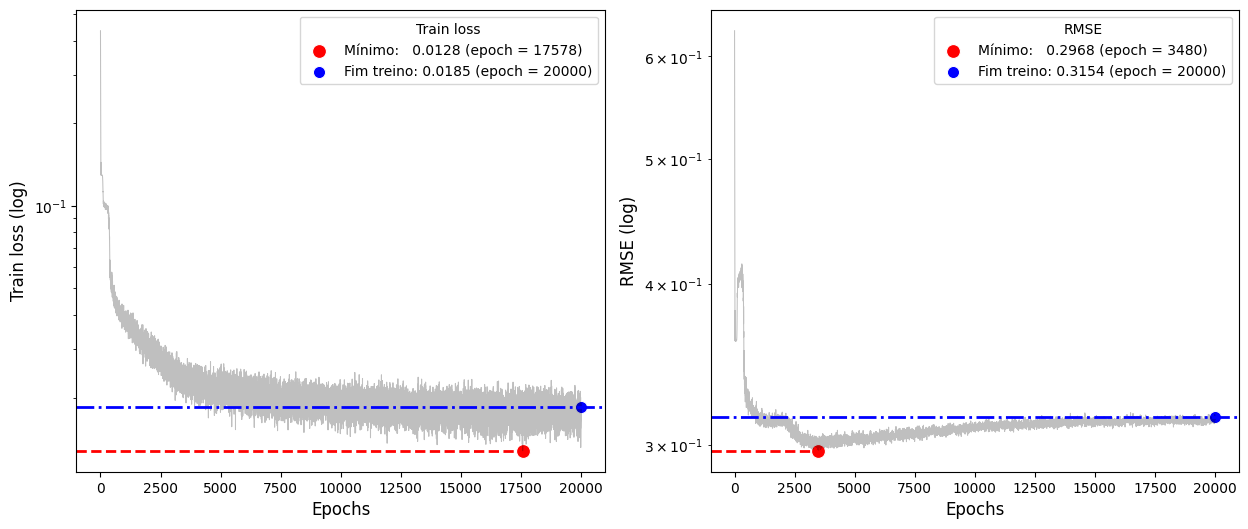

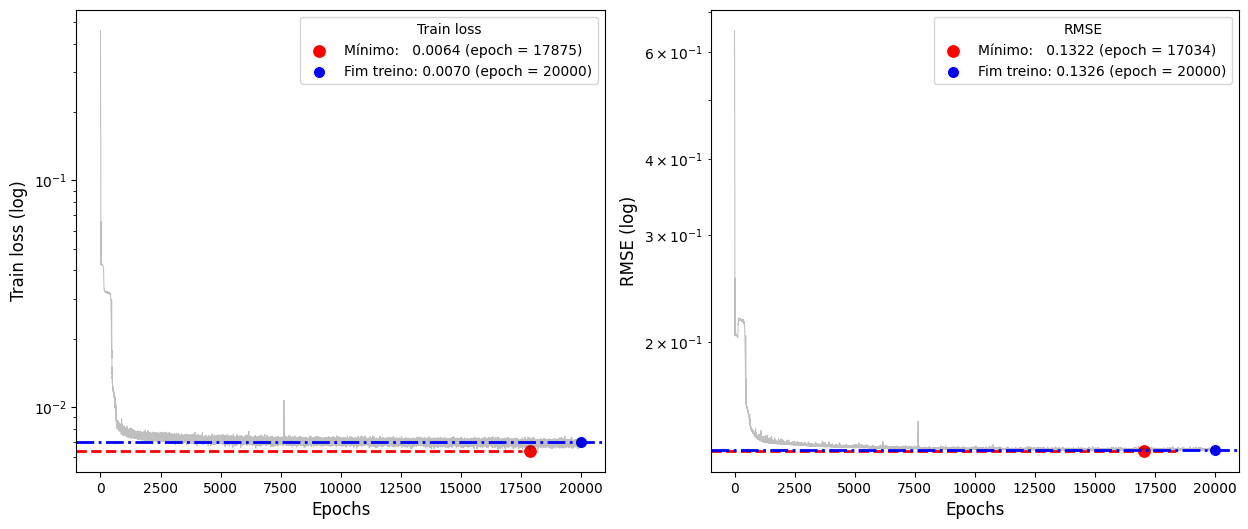

In [5]:
plot_learning(exp.dict_metadata, 0, "energy", 0.3)
plot_learning(exp.dict_metadata, 0, "power", 0.7)

## Hiperparameters

Função de ativação  : [Relu, Prelu]
Otimizador          : [Adam, RMSprop]
Learning rate       : [0.01*, 0.001, 0.005] 

Estudo conduzido para casos extremos: 10% e 70% de valores faltantes
Métricas            : [MAE, RMSE]

Prelu_Adam_0.005 atingiu melhores resultados para poucos dados faltantes (10%) mas em geral todos (exceto LR=0.01 e Prelu_Rmsprop_0.005) performaram de forma similar com muitos dados faltantes (70%) em ambas as métricas

Por critério de tempo de execução foi adotado:
Função de ativação  : [Relu]
Otimizador          : [Adam]
Learning rate       : [0.005] 
Com taxa de aprendizado maior é feita a redução de 20000 epochs para 12000

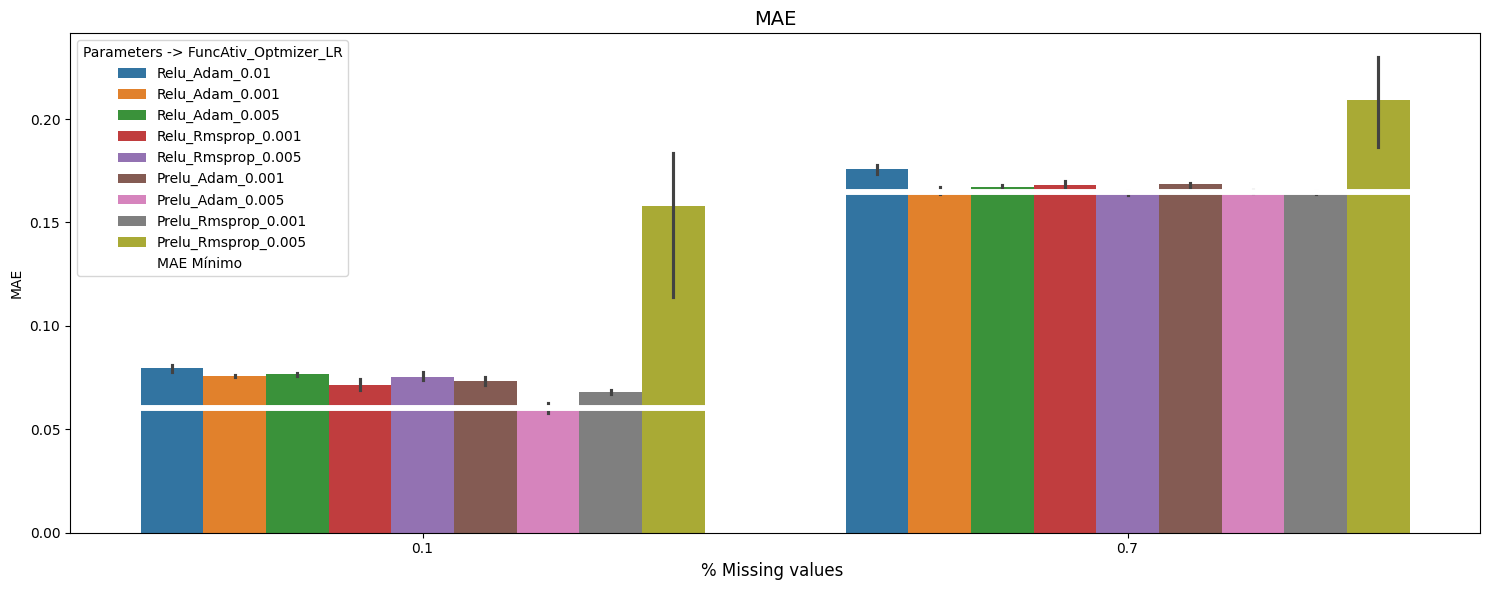

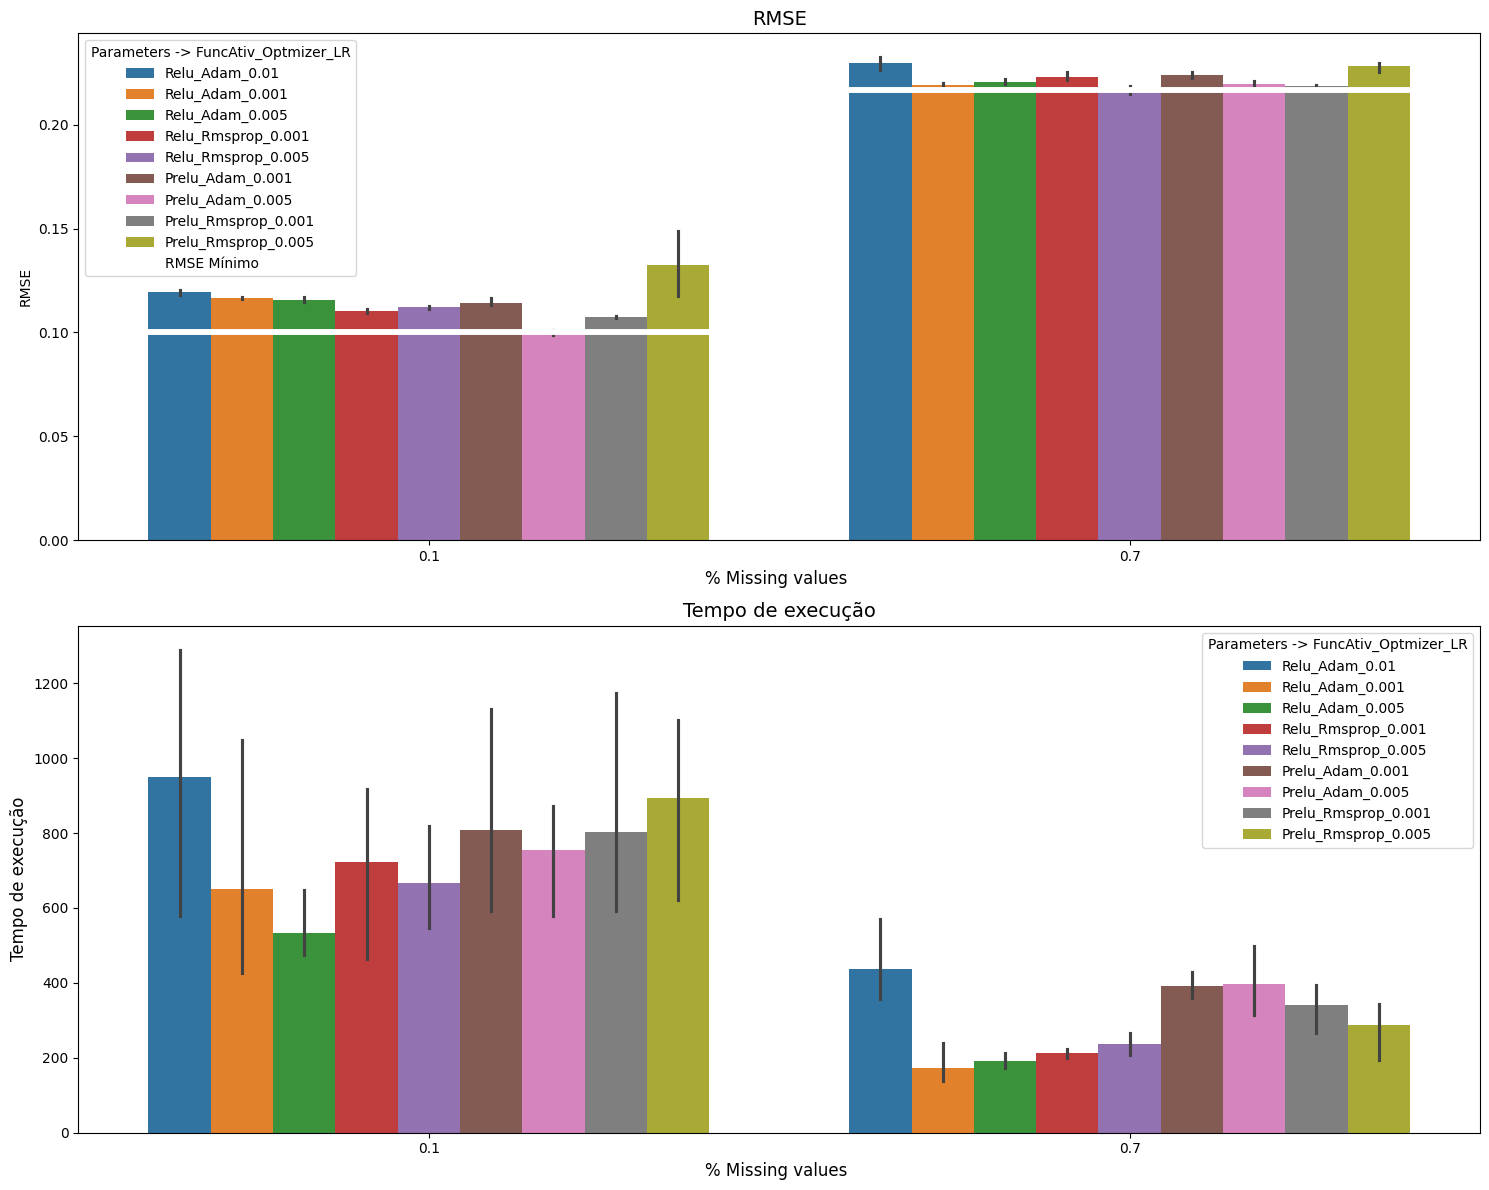

In [6]:
gnn_model.plot_params_gnn(metric = 'MAE', plot_time = False)
gnn_model.plot_params_gnn(metric = 'RMSE')

# Visualização datasets

Concrete: Análise univariada com ~1000 observações
Power: Análise univariada com ~10000 observações
Energy: Análise multivariada (2 labels no original, adotado 1 label no presente trabalho)
Bank: Análise univariada, única com presença de variáveis categóricas (a título de exploração, uma vez que a rede não está programada para lidar com imputação de dados categóricos, mas gostaríamos de ver como ela performa nesse caso)

Tentativa de visualização da similaridade dos datasets via PCA com 3 componentes, explica bem os datasets da UCI e pouco (~50%) do dataset de banco, provavelmente devidoa  grande quantidade de variáveis categóricas, mas é possivel ver que datasets escolhidos fornecem relativa diversidade para os testes.

As comparações serão pautadas principalmente utilizando os datasets Concrete e Power, uma vez que tem características similares (análise univariada e somente variáveis numéricas no dataset original), tendo como diferença principal o tamanho do conjunto de dados.

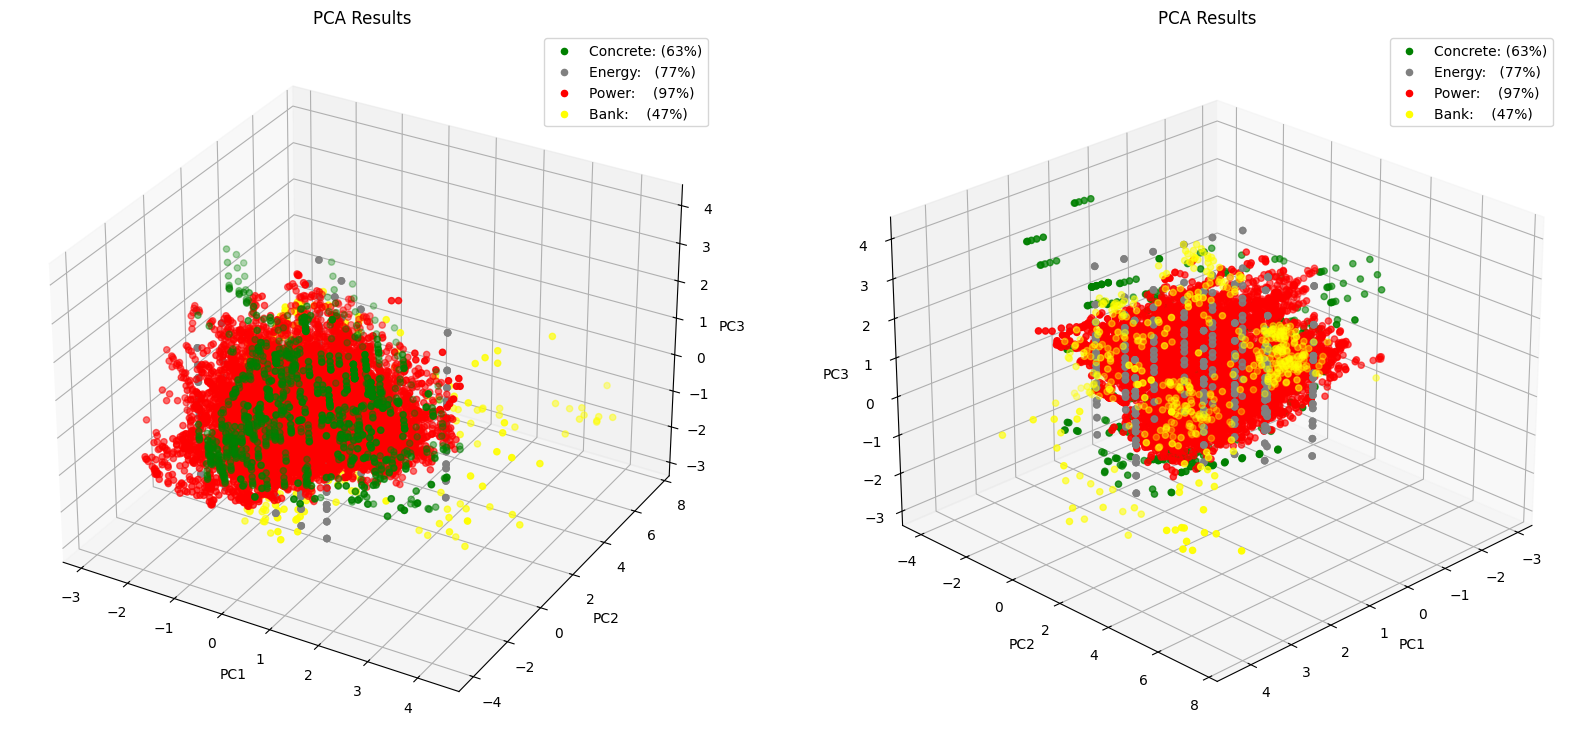

In [7]:
view_pca(exp.data_dict)

# Análise métodos de Imputação

Utilizados métodos (sem otimização):
- Média
- KNN
- MICE
- SVD
- Spectral (explicar -> fancyimputer)

Comparado com GRAPE (GNN sem otimização)

Melhores: GNN - MICE - KNN

RMSE: GRAPE sempre melhor, MICE é baseline em quase todos

MAE: dataset grande(power) com 50% média melhor que KNN, MICE continua bom, KNN-> melhorar chute número clusters?

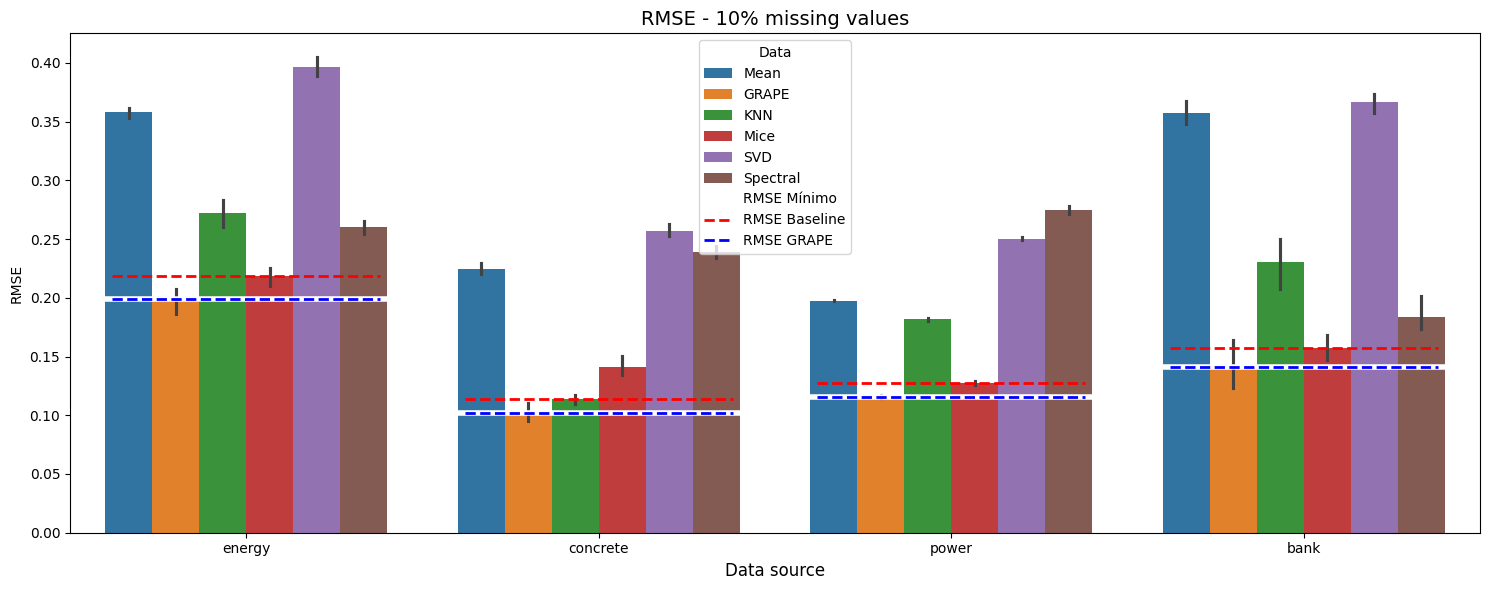

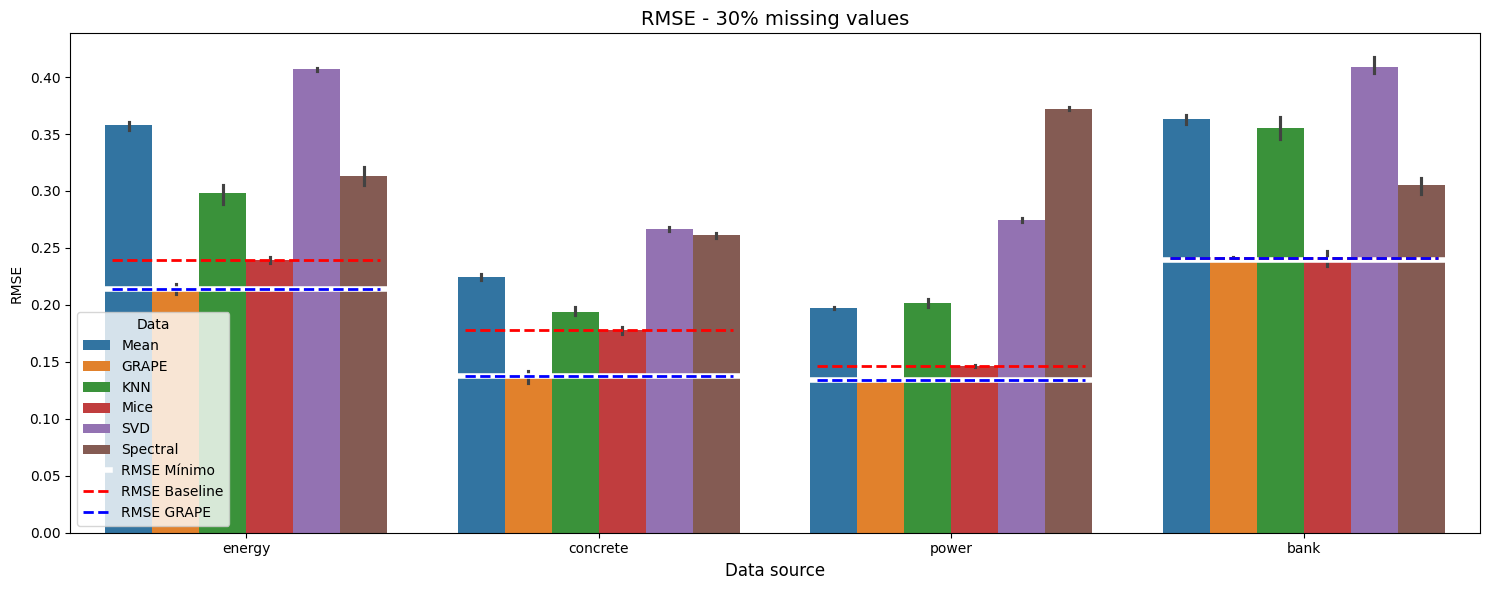

In [8]:
exp.plot_error_bars(metric = 'RMSE', exist_val_percent = 0.90)
exp.plot_error_bars(metric = 'RMSE', exist_val_percent = 0.70)

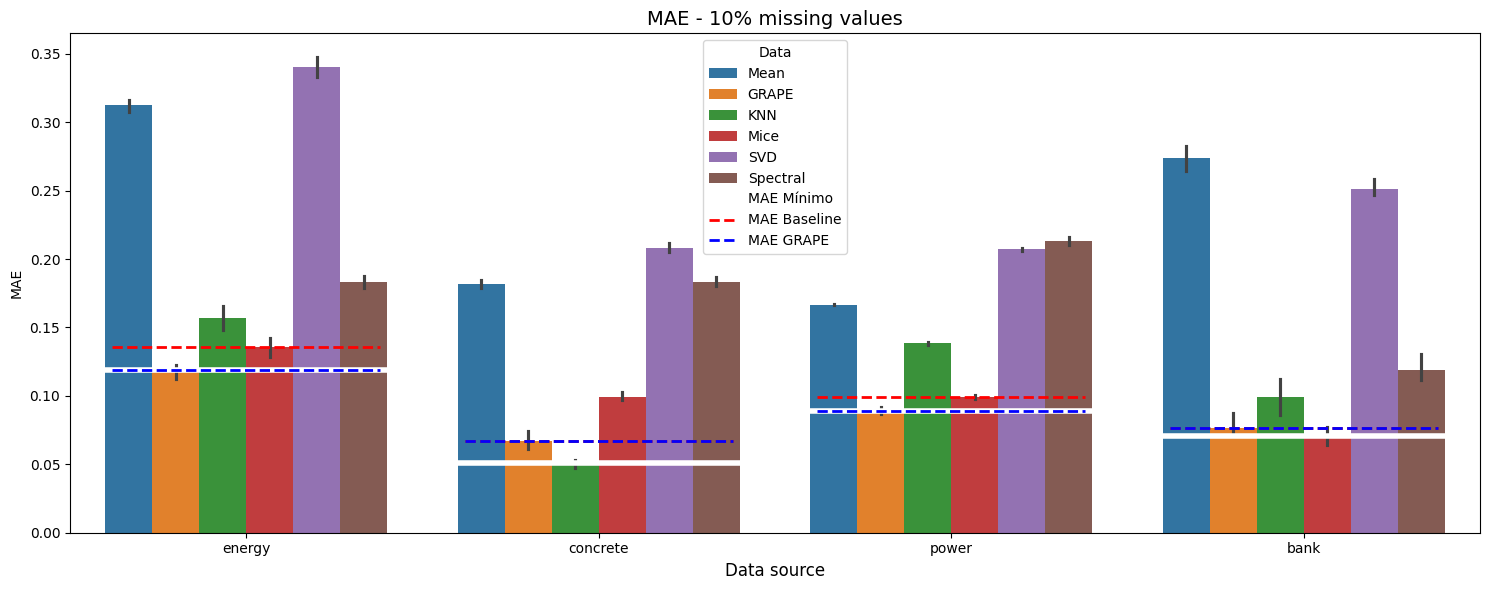

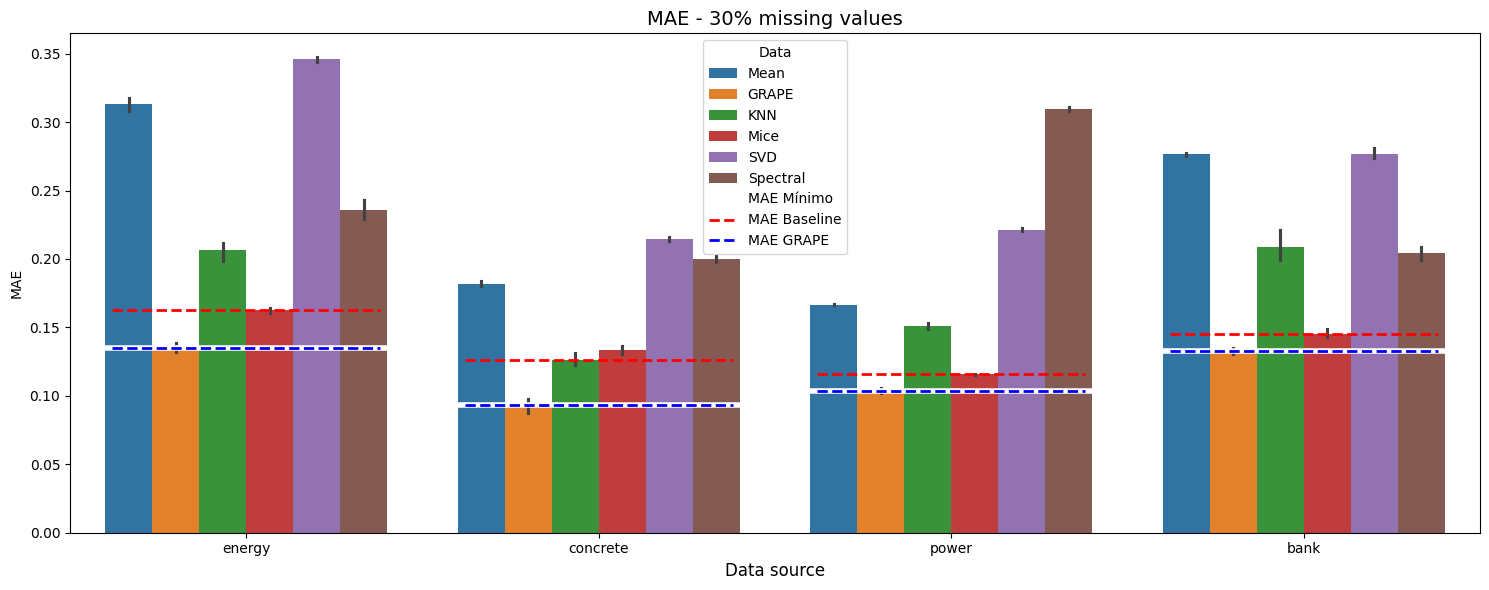

In [9]:
exp.plot_error_bars(metric = 'MAE', exist_val_percent = 0.90)
exp.plot_error_bars(metric = 'MAE', exist_val_percent = 0.70)

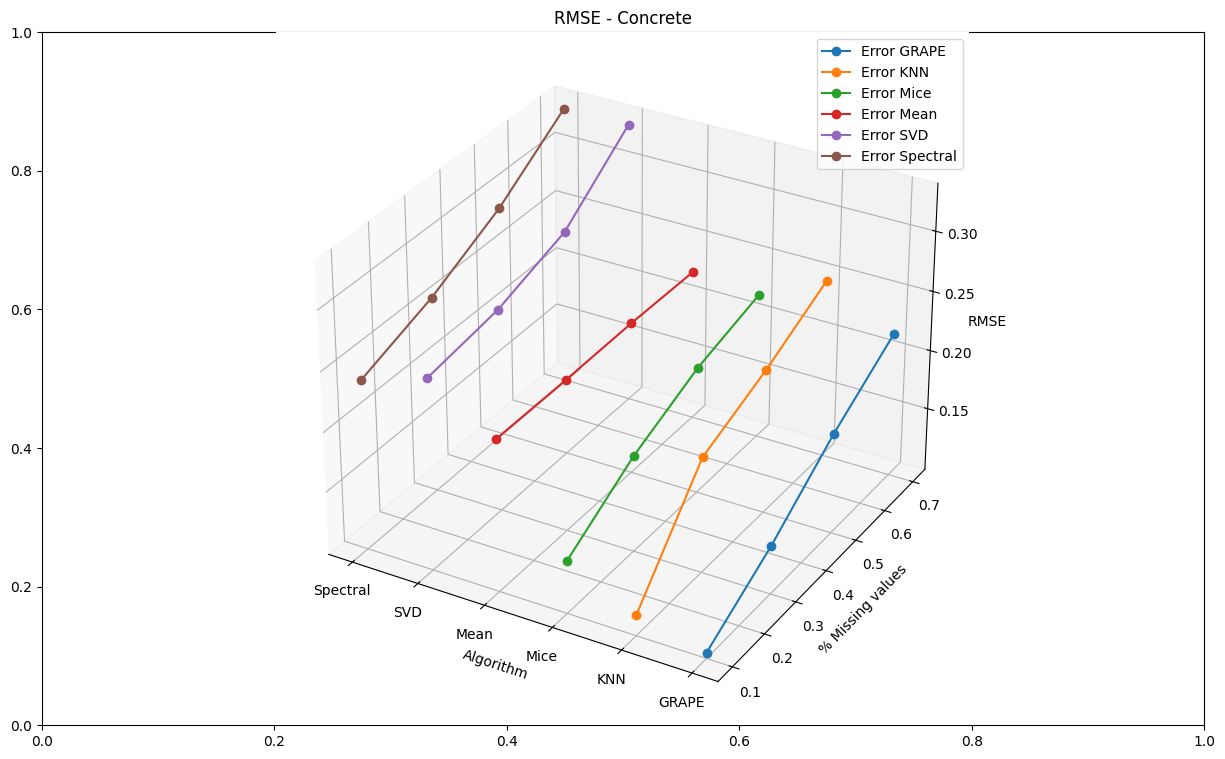

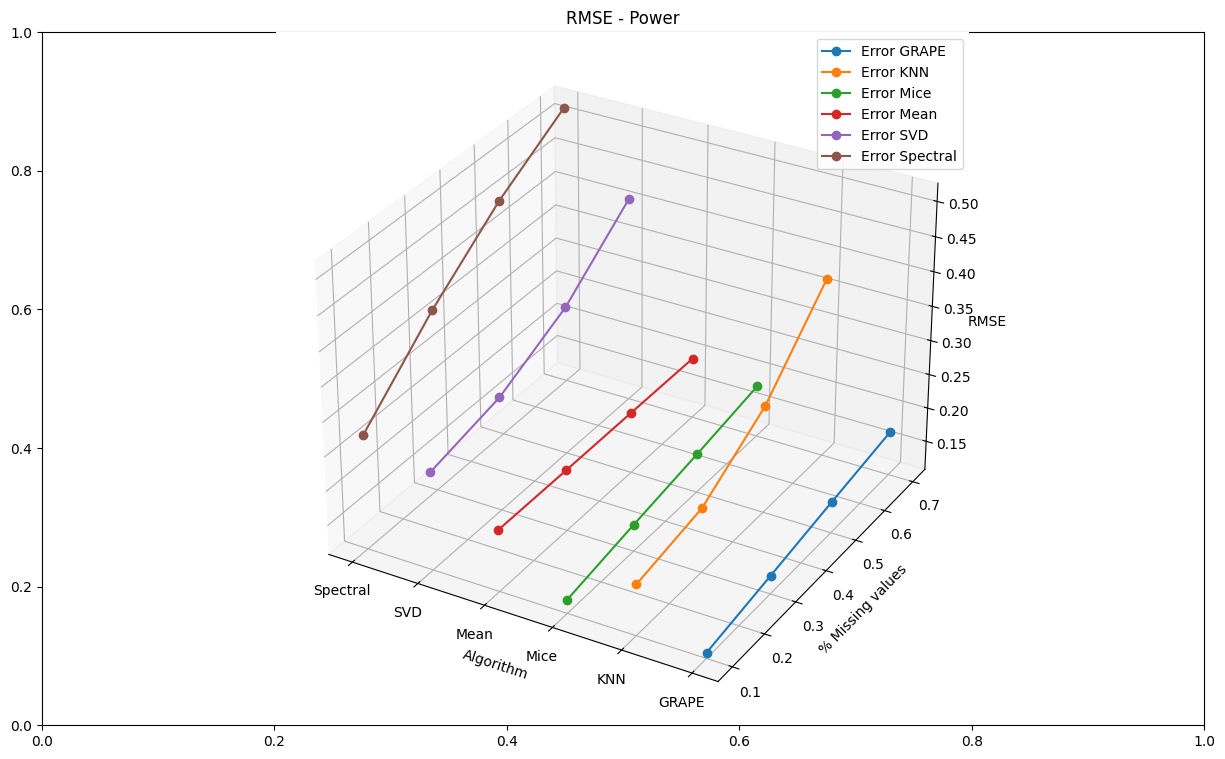

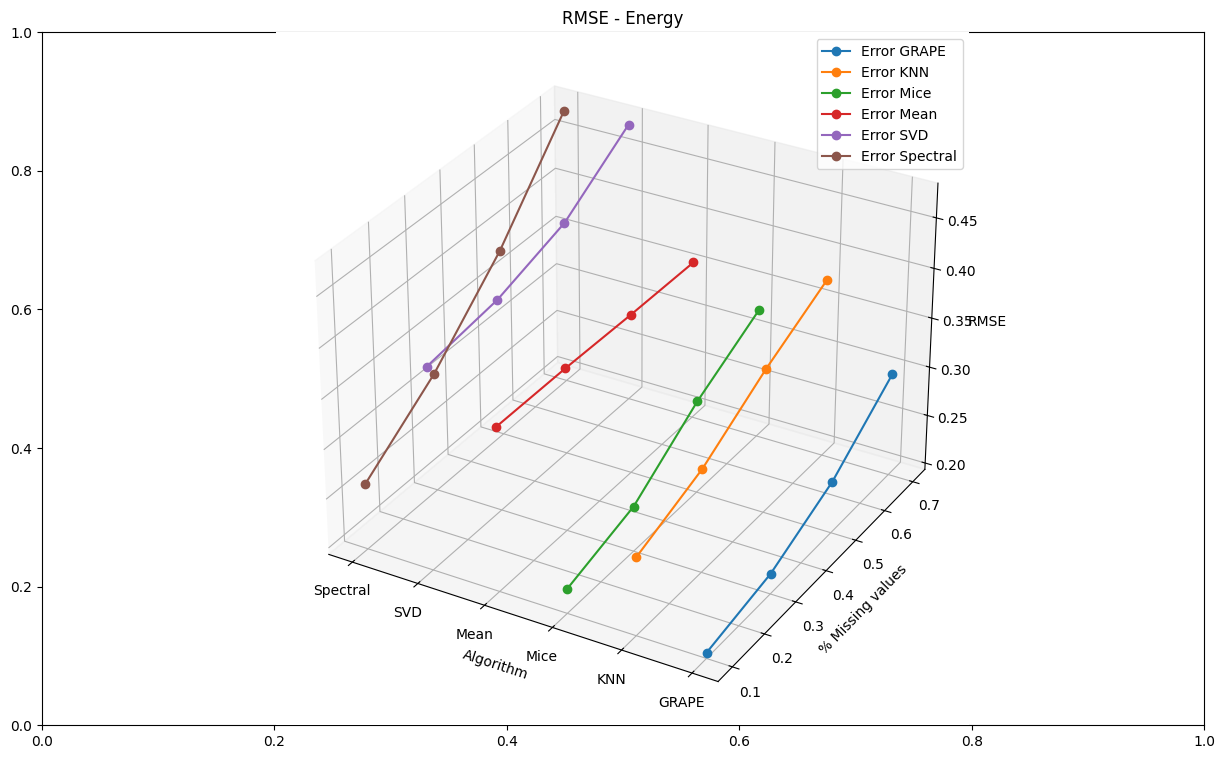

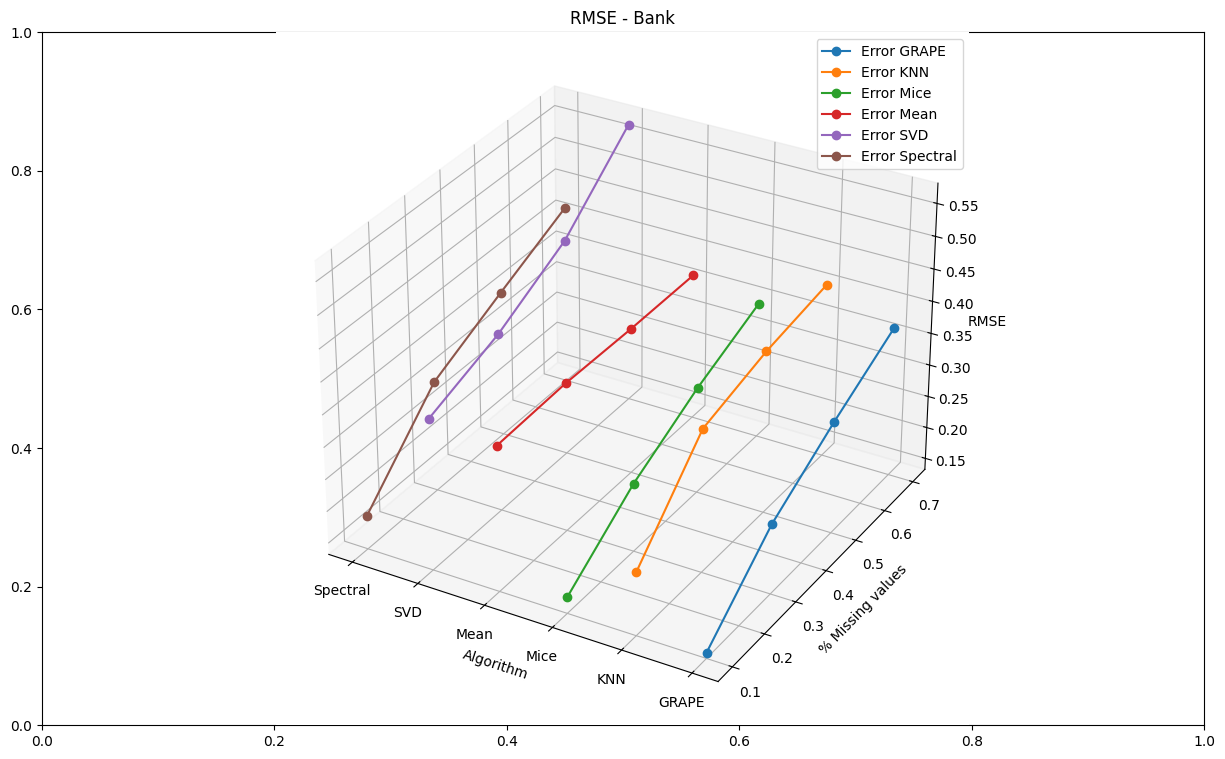

In [10]:
exp.plot_error_line(data = 'concrete', metric = 'RMSE')
exp.plot_error_line(data = 'power', metric = 'RMSE')
exp.plot_error_line(data = 'energy', metric = 'RMSE')
exp.plot_error_line(data = 'bank', metric = 'RMSE')

# Análise da influência da Imputação na Predição

Algoritmos de regressão utilizados (sem otimização de hiperparâmetros):

Linear Regression,
Elastic Net CV,
Polynomial Features,
Lasso, (obs Aplica Lasso na Polynomial, sendo estimado alpha com CV)
Decision Tree,
Random Forest,
Gradient Boosting,
KNeighbors Uniform,
KNeighbors Distance

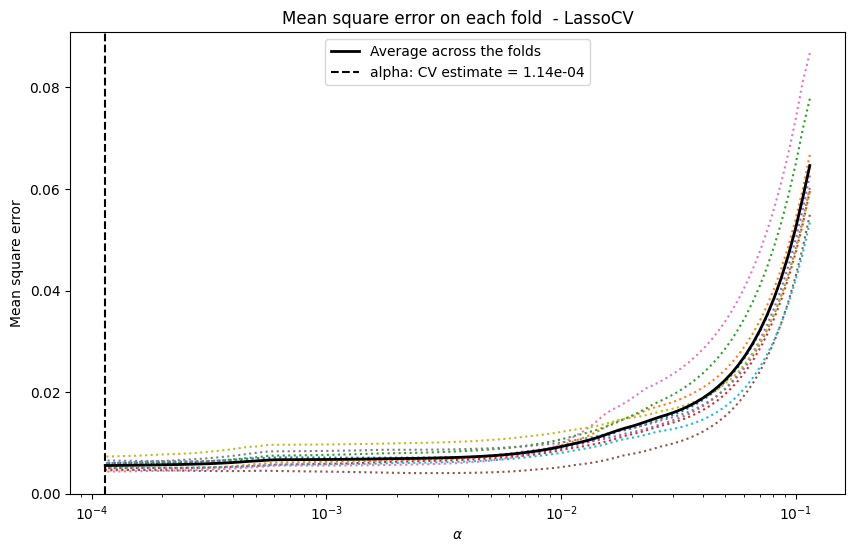

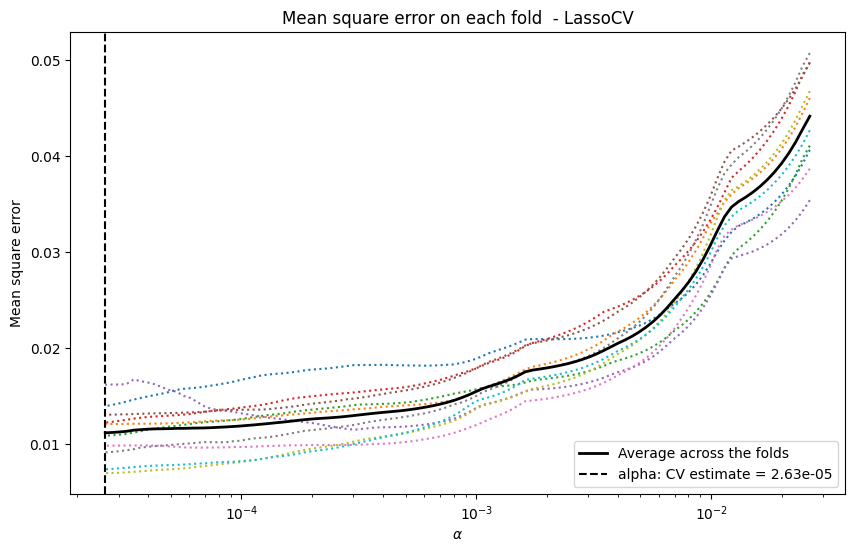

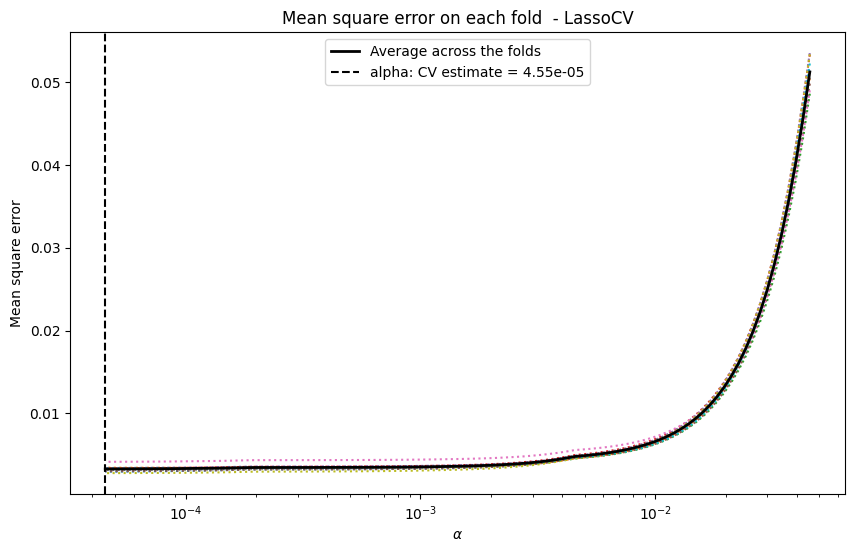

Conjunto de Dados: 'Energy':
Treino:	614	(80%)
Teste:	154	(20%)
Total:	768

Conjunto de Dados: 'Concrete':
Treino:	824	(80%)
Teste:	206	(20%)
Total:	1030

Conjunto de Dados: 'Power':
Treino:	7654	(80%)
Teste:	1914	(20%)
Total:	9568

Conjunto de Dados: 'Bank':
Treino:	400	(80%)
Teste:	100	(20%)
Total:	500


In [11]:
# Obs. Utiliza-se cross validation para estimação do parâmetro alpha da regularização Lasso no modelo Polynomial
exp_pred.compile_predict()

Nas visualizações abaixo:
GRAPE não foi tão bem, treinamento parou cedo demais

Gradient boosting e Random forest generalizaram melhor
Inclusive melhor resultado (RMSE) foi obtido fazendo o input dos valores com a média dos dados em alguns casos

Regressão linear/polinomial muito ruim com os dados que tiverem imputação muito ruim (SVD e spectral)

Menor erro foi ~300% do erro para os dados "Concrete" com 30% de valores faltantes

Fica evidente, comparando os dados "Concrete" com "Power" que a maior disponibilidade de dados no conjunto Power refletiu em menores erros para grande parte dos algoritmos de regressão

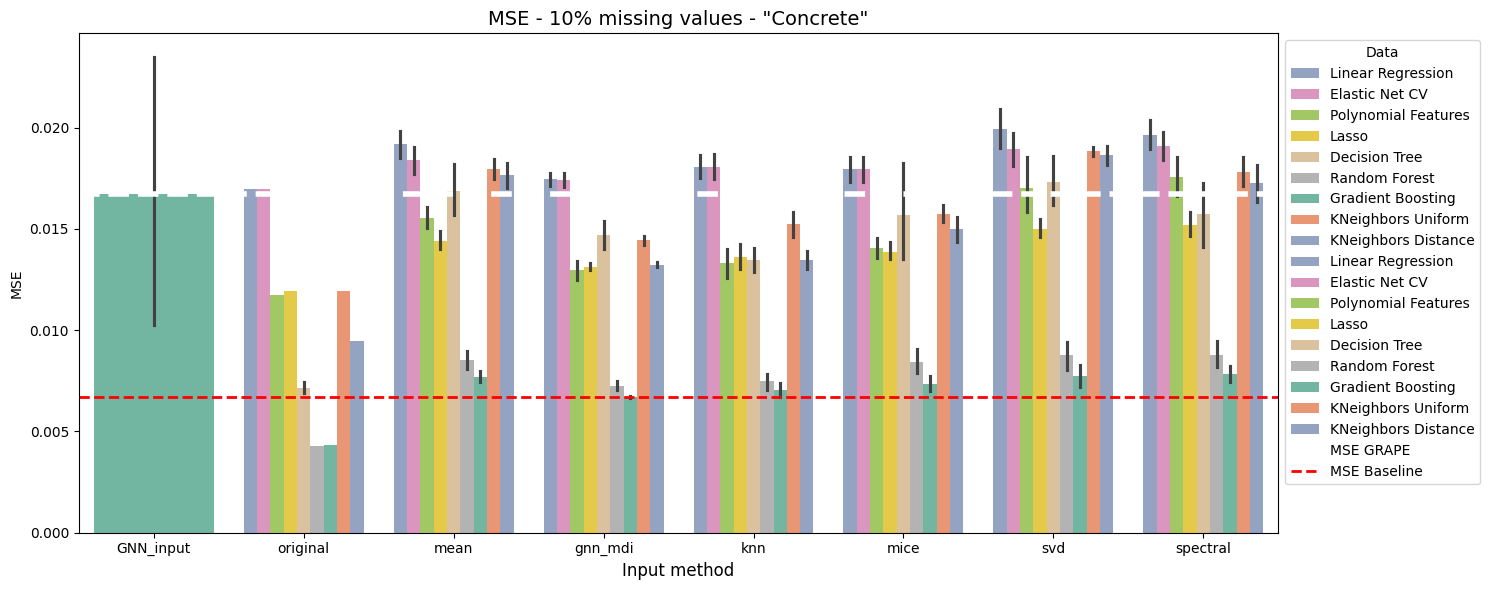

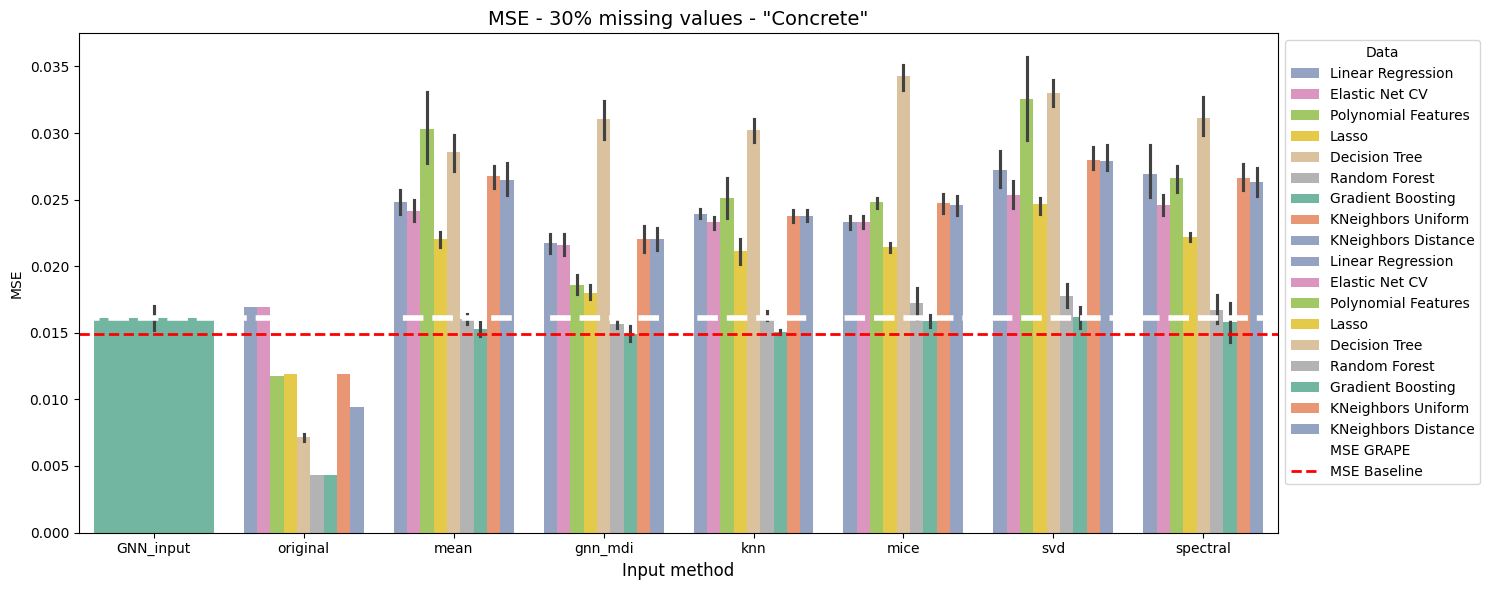

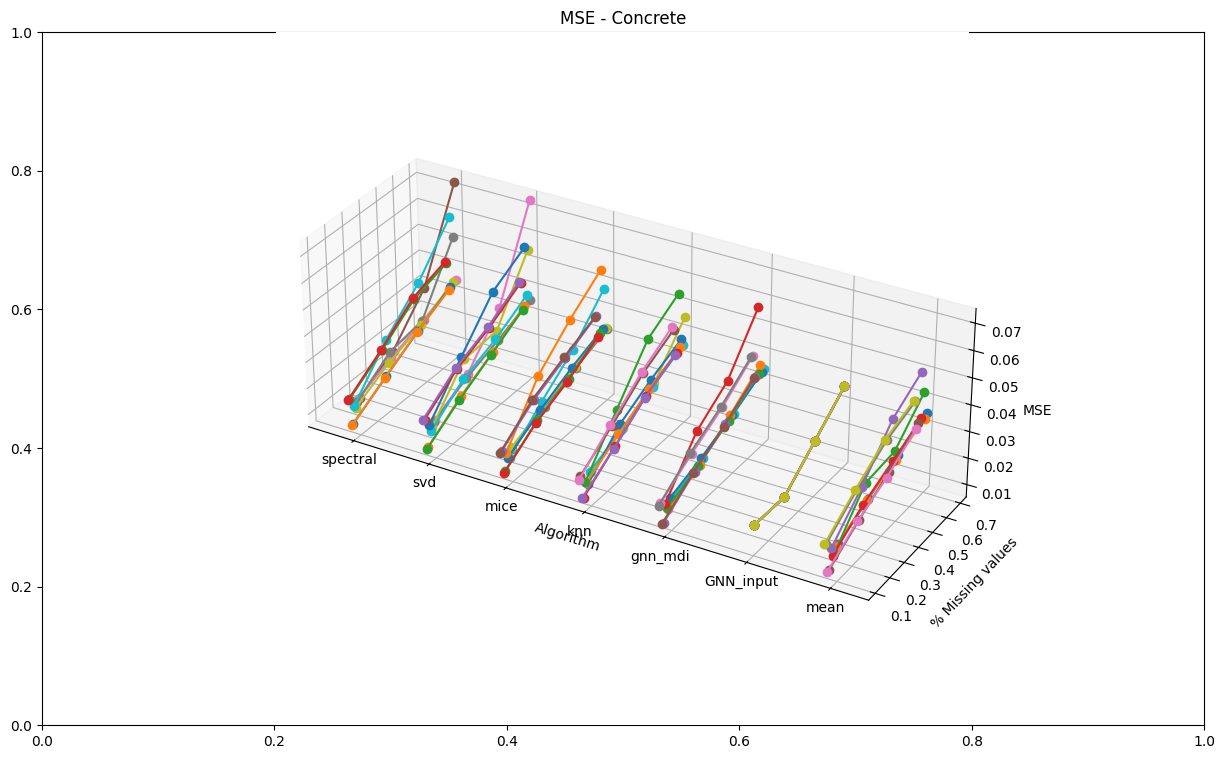

In [12]:
# exp_pred.plot_predict_~(dataset, % valores existentes, metrica(MSE/MAE)
exp_pred.plot_predict_bars("concrete", 0.90, "MSE")
exp_pred.plot_predict_bars("concrete", 0.70, "MSE")
exp_pred.plot_predict_error('concrete', 'MSE')

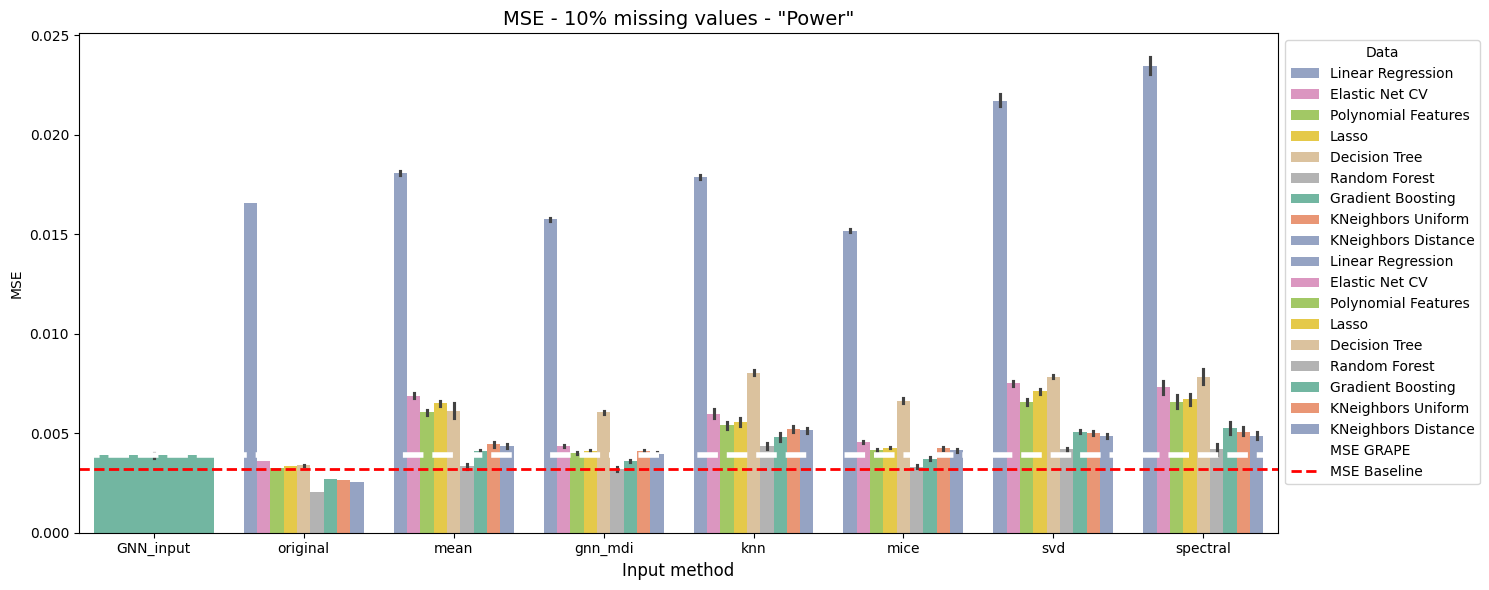

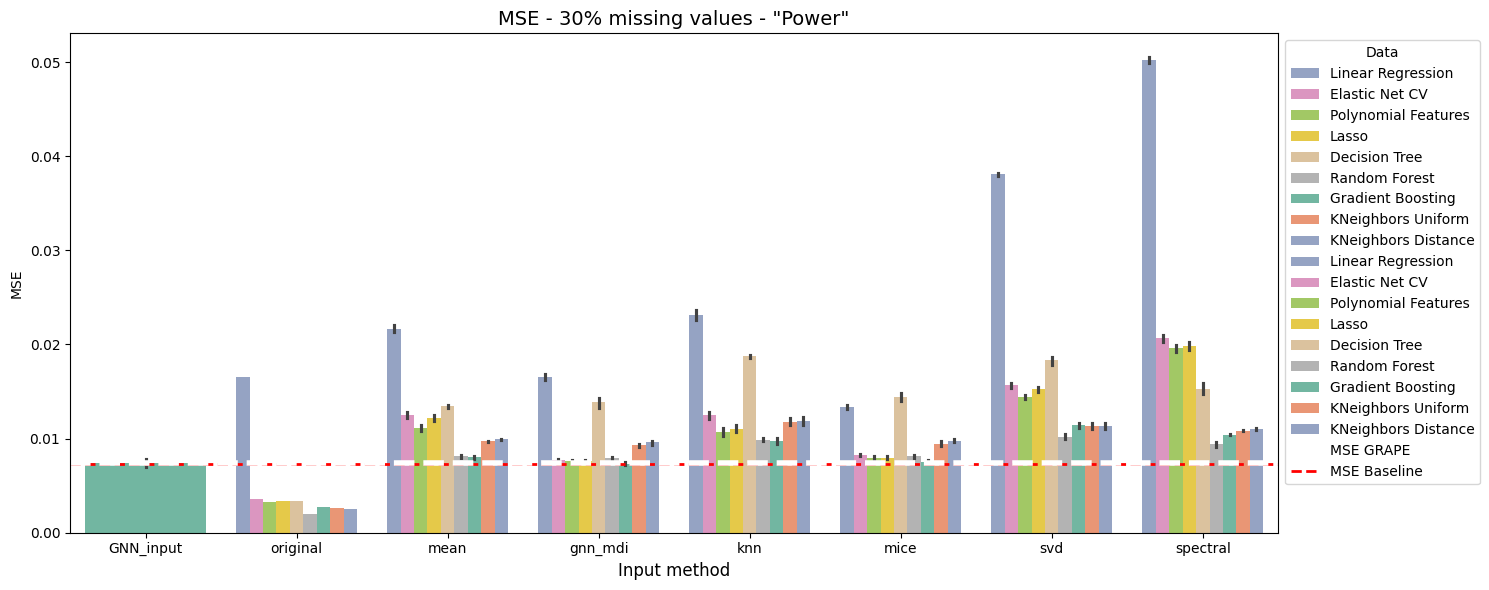

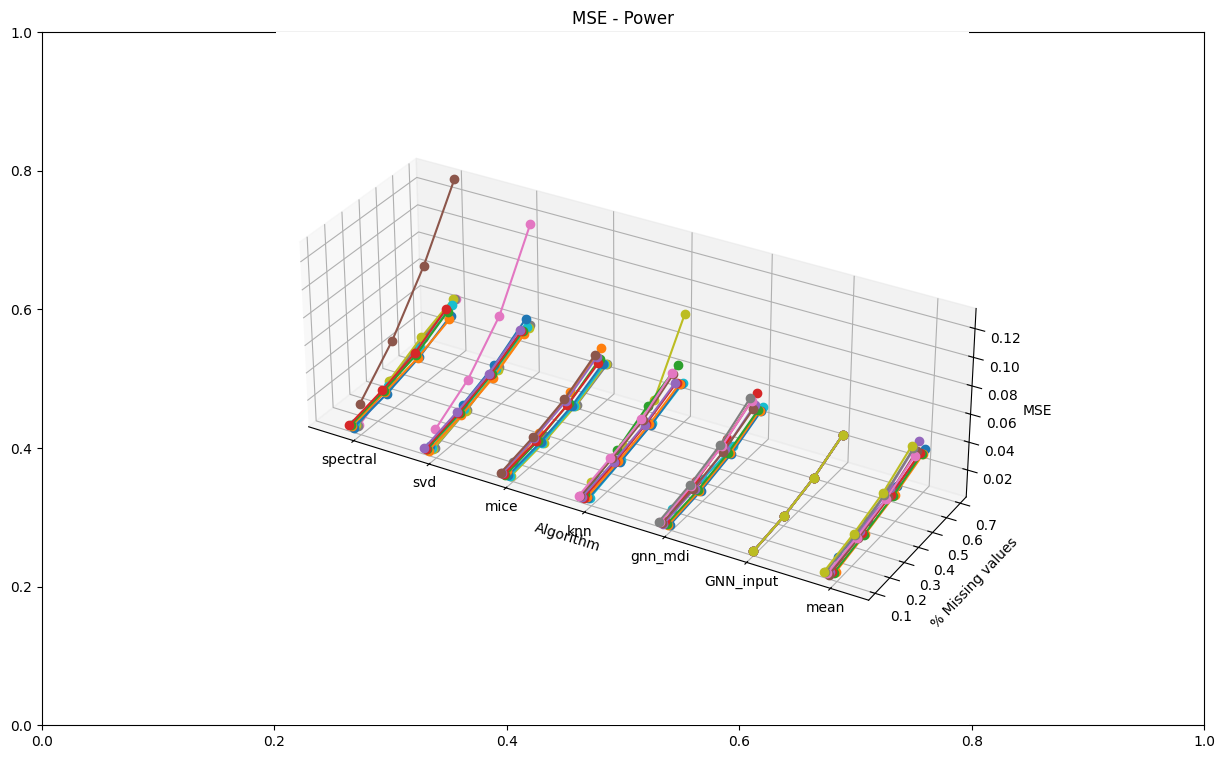

In [13]:
exp_pred.plot_predict_bars("power", 0.90, "MSE")
exp_pred.plot_predict_bars("power", 0.70, "MSE")
exp_pred.plot_predict_error('power', 'MSE')

# Datasets properties

https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set
https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
https://www.kaggle.com/datasets/gova26/airpressure

## Concrete dataset

Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
Age -- quantitative -- Day (1~365) -- Input Variable

Concrete compressive strength -- quantitative -- MPa

## Energy dataset

X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution

y1 Heating Load
y2 Cooling Load

## Power dataset

Variables:
Temperature (T) in the range 1.81°C and 37.11°C,
Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
Relative Humidity (RH) in the range 25.56% to 100.16%
Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg

Target:
Net hourly electrical energy output (PE) 420.26-495.76 MW